Link: https://tinyurl.com/pqtsolutions2

# Workshop 2: Making Predictions from Other Assets

Welcome to this introductory workshop on quantitative finance! In this workshop, we'll explore:

1. **Exploratory Data Analysis (EDA)** - Understanding stock price data from multiple stocks
2. **Betas** - How prices relate to each other
3. **Linear Regression** - How to predict a stock's return from other stock returns
4. **Statistical Testing** - Validating our signals with t-statistics
5. **Backtesting** - Testing our strategy on historical data
6. **Signal to Trades** - Converting predictions into actual trading decisions

We'll focus on a set of stocks and try to predict the price movement at a given time from the price movements of the other stocks at the same time.

## 1: Load the Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adhoppin/financial-data")

print("Path to dataset files:", path)

100%|██████████| 4.22M/4.22M [00:00<00:00, 114MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adhoppin/financial-data/versions/1


## 2: Extract the Relevant Stocks

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# List all stocks under the 'stocks' directory
import os
stocks_dir = os.path.join(path, 'Financial Data', 'stocks')
all_stocks = [f for f in os.listdir(stocks_dir) if f.endswith('.csv')]
print("Available stocks:", all_stocks)

Available stocks: ['PYPL.csv', 'GOOGL.csv', 'AMZN.csv', 'PEP.csv', 'ADBE.csv', 'CMCSA.csv', 'SBUX.csv', 'TSLA.csv', 'AMD.csv', 'INTC.csv', 'NFLX.csv', 'AMGN.csv', 'QCOM.csv', 'CSCO.csv', 'GOOG.csv', 'META.csv', 'NVDA.csv', 'GILD.csv', 'AAPL.csv', 'MSFT.csv']


In [ ]:
predictors = ['GOOG', 'MSFT', 'AMZN', 'META', 'NVDA']
responder = 'AAPL'

In [ ]:
stock_paths = {stock: os.path.join(stocks_dir, f"{stock}.csv") for stock in predictors + [responder]}
# Load all stock data
stock_data = {stock: pd.read_csv(stock_paths[stock]) for stock in stock_paths}

## 3. Merging the Datasets

In [ ]:
stock_data['AAPL']

,Date,Open,High,Low,Close,Volume,Symbol,YTD Gains
0,2002-12-31,0.250000,0.256429,0.249107,0.255893,200726400,AAPL,0.000000
1,2003-01-02,0.256429,0.266429,0.256250,0.264286,181428800,AAPL,0.032799
2,2003-01-03,0.264286,0.266607,0.260536,0.266071,147453600,AAPL,0.039774
3,2003-01-06,0.268393,0.274643,0.265714,0.266071,390532800,AAPL,0.039774
4,2003-01-07,0.264107,0.267857,0.258393,0.265179,342344800,AAPL,0.036289
...,...,...,...,...,...,...,...,...
5141,2023-06-05,182.630005,184.949997,178.039993,179.580002,121946500,AAPL,700.777725
5142,2023-06-06,179.970001,180.119995,177.429993,179.210007,64848400,AAPL,699.331827
5143,2023-06-07,178.440002,181.210007,177.320007,177.820007,61944600,AAPL,693.899872
5144,2023-06-08,177.899994,180.839996,177.460007,180.570007,50214900,AAPL,704.646551


In [ ]:
stock_data['GOOG']

,Date,Open,High,Low,Close,Volume,Symbol,YTD Gains
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216,GOOG,0.000000
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488,GOOG,0.079430
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939,GOOG,0.090293
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159,GOOG,0.045146
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512,GOOG,0.056408
...,...,...,...,...,...,...,...,...
4730,2023-06-05,124.610001,127.989998,124.379997,126.629997,22672500,GOOG,49.669569
4731,2023-06-06,126.599998,128.880005,125.970001,127.910004,19450100,GOOG,50.181749
4732,2023-06-07,127.574997,129.550003,122.629997,122.940002,34179300,GOOG,48.193059
4733,2023-06-08,122.584999,123.730003,122.010002,122.669998,24815000,GOOG,48.085020


In [ ]:
# Rename each dataframe's 'Close' column to its stock symbol, and remove other columns except 'Date'

full_df = None

for stock, data in stock_data.items():
    df = data[['Date', 'Close']].copy()
    df.rename(columns={'Close': stock}, inplace=True)
    if full_df is None:
        full_df = df
    else:
        full_df = pd.merge(full_df, df, on='Date', how='inner')


In [ ]:
full_df

,Date,GOOG,MSFT,AMZN,META,NVDA,AAPL
0,2012-05-18,14.953949,29.270000,10.692500,38.230000,3.020000,18.942142
1,2012-05-21,15.295419,29.750000,10.905500,34.029999,3.072500,20.045713
2,2012-05-22,14.963912,29.760000,10.766500,31.000000,3.035000,19.891787
3,2012-05-23,15.179603,29.110001,10.864000,32.000000,3.110000,20.377144
4,2012-05-24,15.035145,29.070000,10.762000,33.029999,3.027500,20.190001
...,...,...,...,...,...,...,...
2778,2023-06-05,126.629997,335.940002,125.300003,271.390015,391.709991,179.580002
2779,2023-06-06,127.910004,333.679993,126.610001,271.119995,386.540009,179.210007
2780,2023-06-07,122.940002,323.380005,121.230003,263.600006,374.750000,177.820007
2781,2023-06-08,122.669998,325.260010,124.250000,264.579987,385.100006,180.570007


## 4: Explore the Data

<Axes: xlabel='Date'>

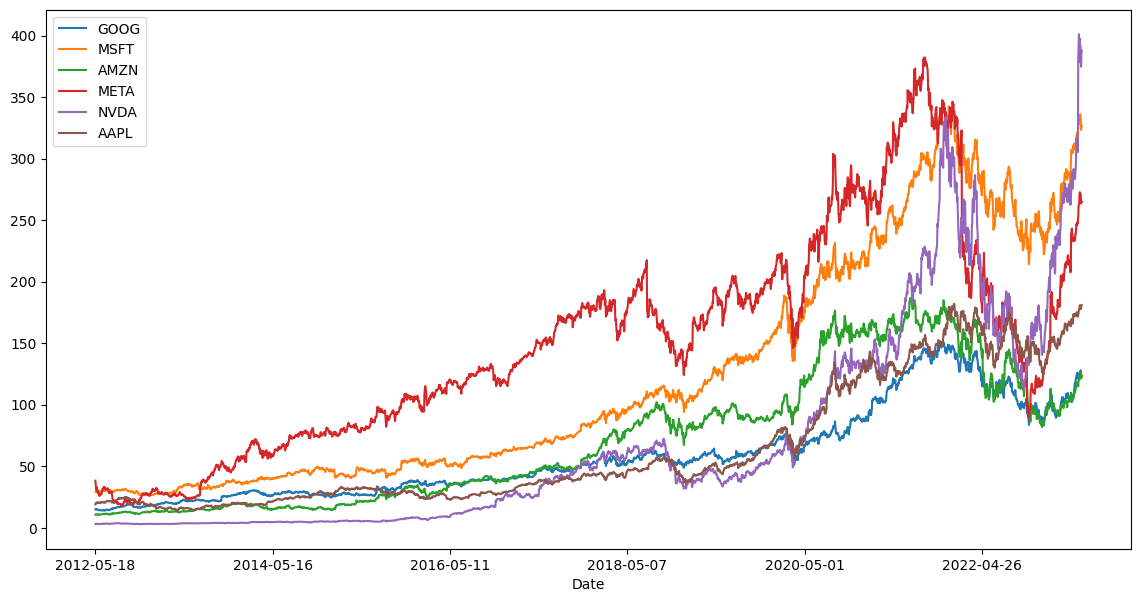

In [ ]:
full_df.plot(x='Date', y=predictors + [responder], figsize=(14, 7))

array([[<Axes: title={'center': 'GOOG'}>,
        <Axes: title={'center': 'MSFT'}>],
       [<Axes: title={'center': 'AMZN'}>,
        <Axes: title={'center': 'META'}>],
       [<Axes: title={'center': 'NVDA'}>,
        <Axes: title={'center': 'AAPL'}>]], dtype=object)

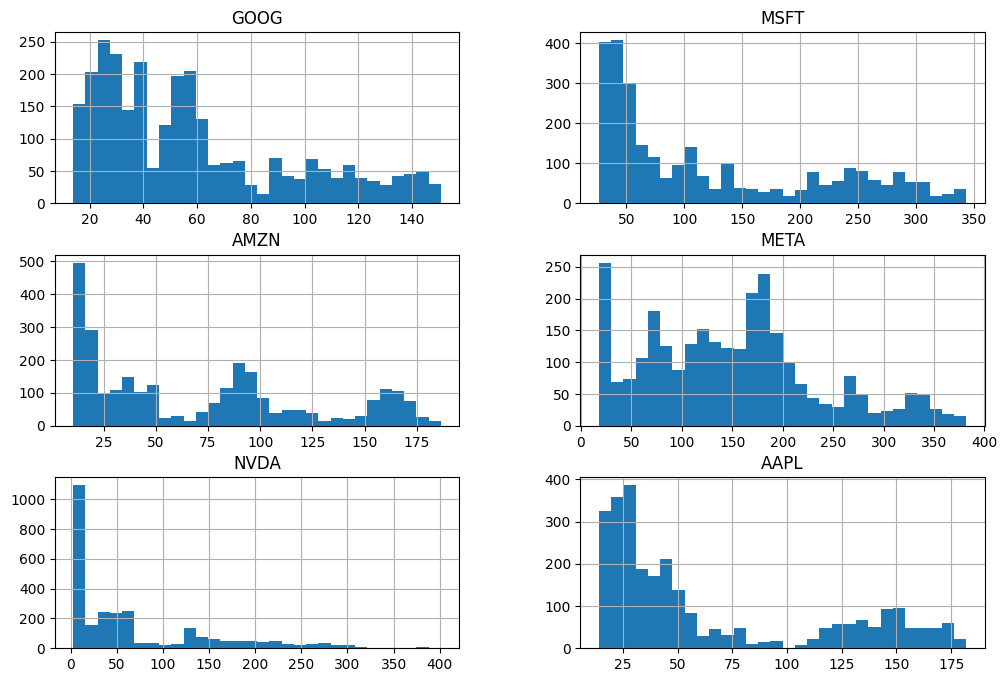

In [ ]:
# Histograms of the prices
full_df[predictors + [responder]].hist(bins=30, figsize=(12, 8))

<Axes: xlabel='GOOG', ylabel='AAPL'>

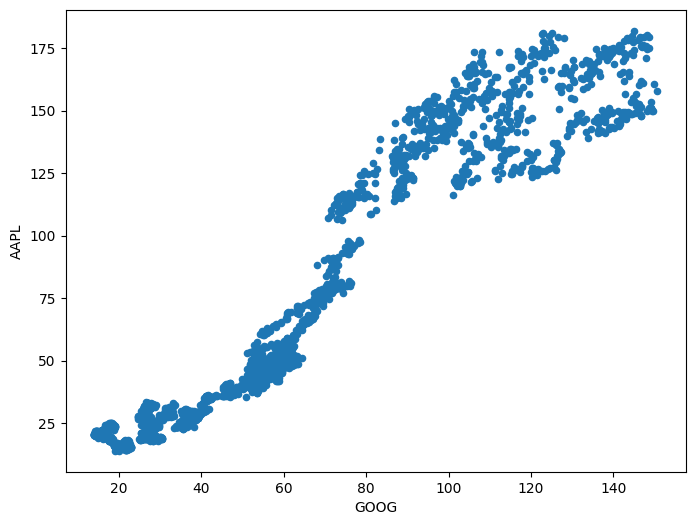

In [ ]:
# Scatterplot responder vs one predictor
full_df.plot.scatter(x='GOOG', y='AAPL', figsize=(8, 6))

<Axes: xlabel='Date'>

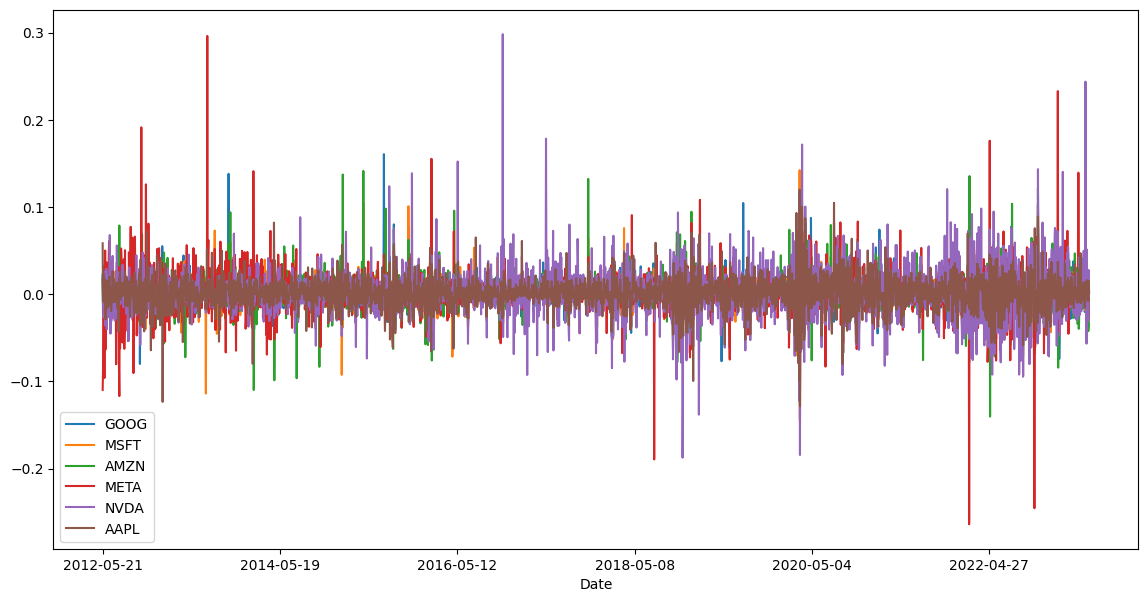

In [ ]:
# Convert to returns
returns_df = full_df.copy()
for stock in predictors + [responder]:
    returns_df[stock] = returns_df[stock].pct_change()
returns_df.dropna(inplace=True)
returns_df.plot(x='Date', y=predictors + [responder], figsize=(14, 7))

array([[<Axes: title={'center': 'GOOG'}>,
        <Axes: title={'center': 'MSFT'}>],
       [<Axes: title={'center': 'AMZN'}>,
        <Axes: title={'center': 'META'}>],
       [<Axes: title={'center': 'NVDA'}>,
        <Axes: title={'center': 'AAPL'}>]], dtype=object)

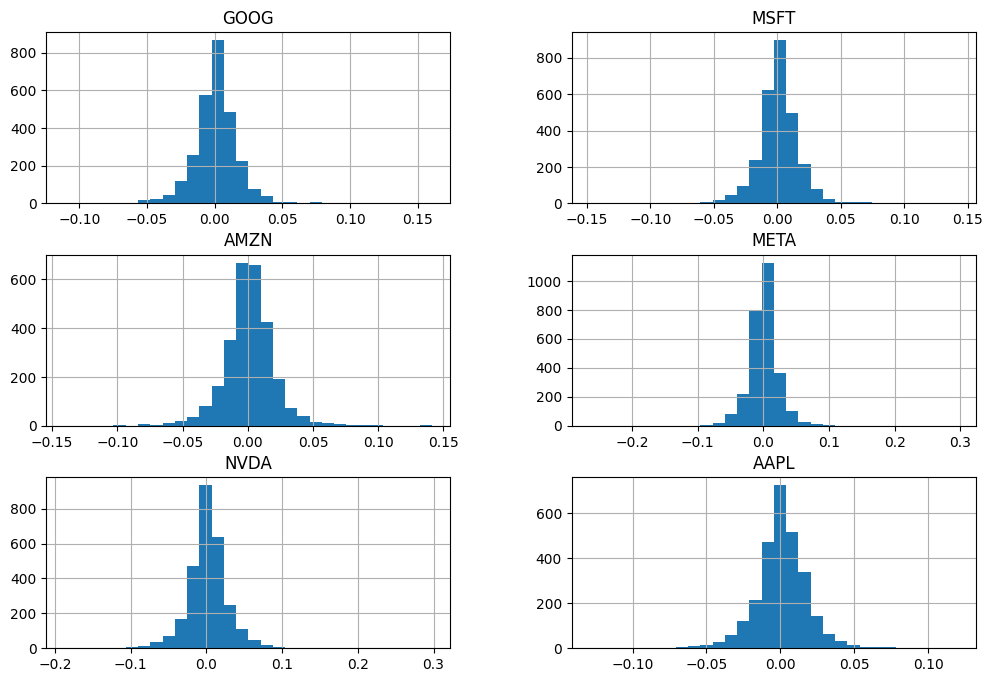

In [ ]:
#Histograms of the returns
returns_df[predictors + [responder]].hist(bins=30, figsize=(12, 8))

<Axes: xlabel='GOOG', ylabel='AAPL'>

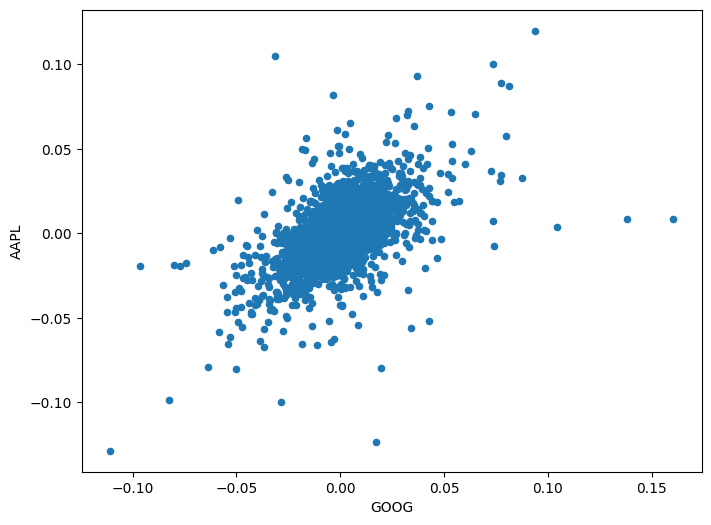

In [ ]:
# Scatter plot again
returns_df.plot.scatter(x='GOOG', y='AAPL', figsize=(8, 6))

In [ ]:
# Histogram of log returns
log_returns_df = full_df.copy()
for stock in predictors + [responder]:
    log_returns_df[stock] = np.log(full_df[stock] / full_df[stock].shift(1))
log_returns_df.dropna(inplace=True)

array([[<Axes: title={'center': 'GOOG'}>,
        <Axes: title={'center': 'MSFT'}>],
       [<Axes: title={'center': 'AMZN'}>,
        <Axes: title={'center': 'META'}>],
       [<Axes: title={'center': 'NVDA'}>,
        <Axes: title={'center': 'AAPL'}>]], dtype=object)

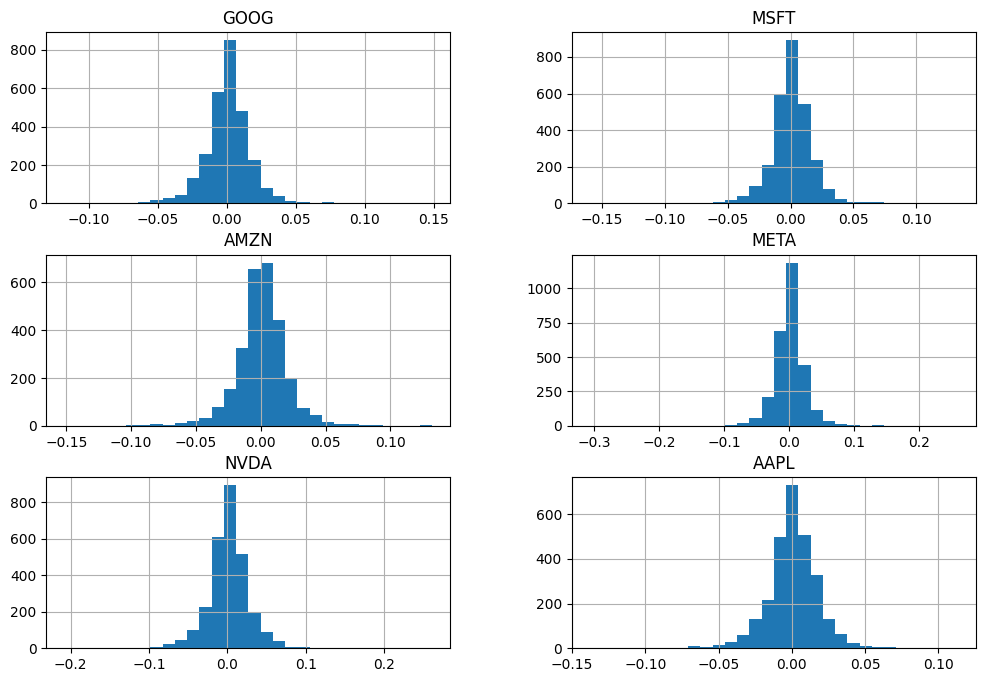

In [ ]:
log_returns_df[predictors + [responder]].hist(bins=30, figsize=(12, 8))

<Axes: xlabel='GOOG', ylabel='AAPL'>

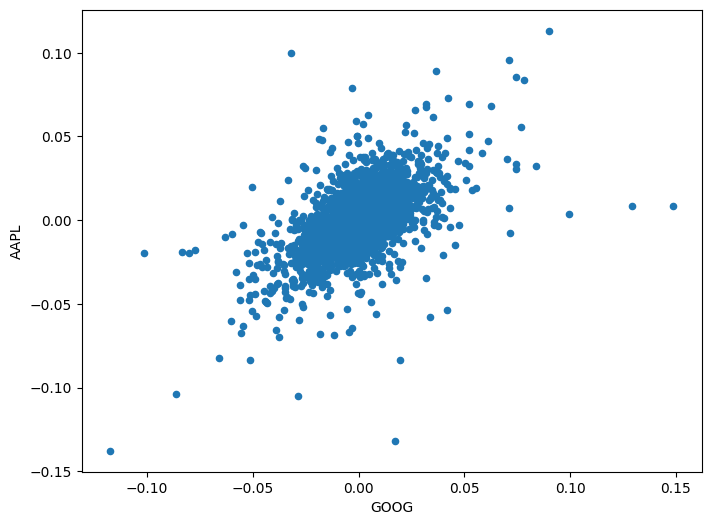

In [ ]:
#Scatter plot of log returns
log_returns_df.plot.scatter(x='GOOG', y='AAPL', figsize=(8, 6))

In [ ]:
log_returns_df.describe()

,GOOG,MSFT,AMZN,META,NVDA,AAPL
count,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000
mean,0.000757,0.000867,0.000879,0.000696,0.001745,0.000811
std,0.017059,0.016914,0.020409,0.025649,0.027825,0.018189
min,-0.117667,-0.159453,-0.151398,-0.306391,-0.207712,-0.137708
25%,-0.006907,-0.006875,-0.008746,-0.010107,-0.011137,-0.007617
50%,0.000696,0.000668,0.000960,0.000876,0.001921,0.000751
75%,0.009051,0.009392,0.011334,0.012629,0.015019,0.010406
max,0.148872,0.132929,0.132178,0.259371,0.260876,0.113157


In [ ]:
log_returns_df['NVDA'].mean() / log_returns_df['NVDA'].std()

np.float64(0.06271948512523565)

In [ ]:
for stock in predictors + [responder]:
    mean = log_returns_df[stock].mean()
    std = log_returns_df[stock].std()
    sharpe_ratio = mean / std
    print(f"{stock}: Mean={mean:.6f}, Std={std:.6f}, Sharpe Ratio={sharpe_ratio:.6f}")

GOOG: Mean=0.000757, Std=0.017059, Sharpe Ratio=0.044380
MSFT: Mean=0.000867, Std=0.016914, Sharpe Ratio=0.051275
AMZN: Mean=0.000879, Std=0.020409, Sharpe Ratio=0.043083
META: Mean=0.000696, Std=0.025649, Sharpe Ratio=0.027130
NVDA: Mean=0.001745, Std=0.027825, Sharpe Ratio=0.062719
AAPL: Mean=0.000811, Std=0.018189, Sharpe Ratio=0.044602


In [ ]:
train_test_split = 0.8
train_df = log_returns_df.iloc[:int(len(log_returns_df) * train_test_split)].copy()
test_df = log_returns_df.iloc[int(len(log_returns_df) * train_test_split):].copy()

## 5: Beta from One Stock to Another

In [ ]:
X = train_df[predictors[0]]
y = train_df[responder]

In [ ]:
X

,GOOG
1,0.022578
2,-0.021912
3,0.014311
4,-0.009562
5,-0.020299
...,...
2221,-0.026586
2222,0.003422
2223,-0.002259
2224,0.007024


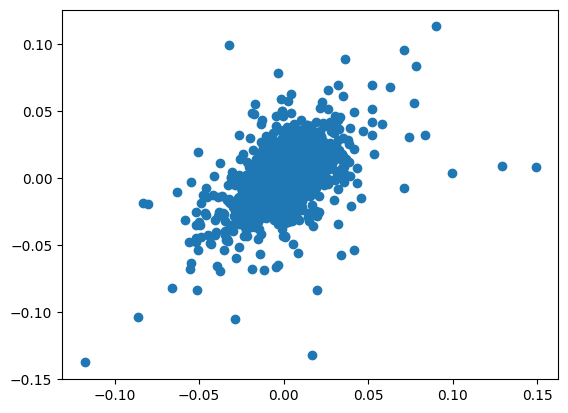

In [ ]:
plt.scatter(X, y)

In [ ]:
# Naive beta: average of (y / X)
beta_naive = (y / X).mean()
beta_naive

np.float64(0.590038059530662)

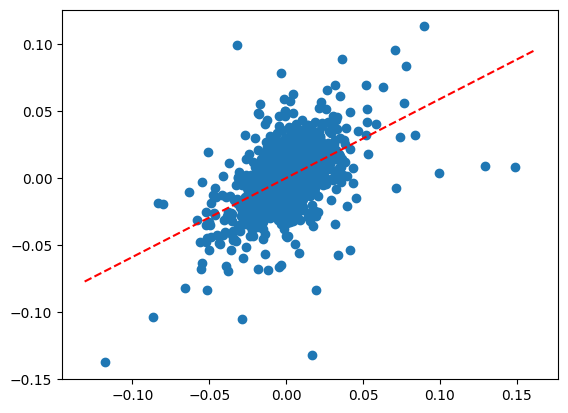

In [ ]:
# plot the beta
plt.scatter(X, y)
x_vals = np.array(plt.gca().get_xlim())
y_vals = beta_naive * x_vals
plt.plot(x_vals, y_vals, '--', color='red')
plt.show()

In [ ]:
# The real beta: project y onto X
cos_theta = np.dot(X, y) / (np.linalg.norm(X) * np.linalg.norm(y))
beta_real = cos_theta * (np.linalg.norm(y) / np.linalg.norm(X))
beta_real


np.float64(0.5919100892375209)

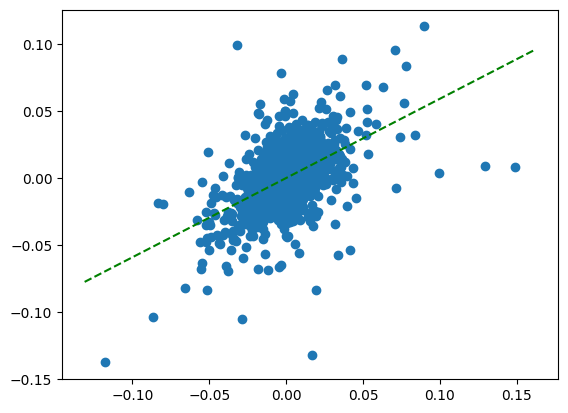

In [ ]:
# plot the beta_real against the beta naive
plt.scatter(X, y)
x_vals = np.array(plt.gca().get_xlim())
y_vals_real = beta_real * x_vals
plt.plot(x_vals, y_vals_real, '--', color='green')
plt.show()



Side note: What does the beta from y to X look like?

Why does it look so bad?

## 6: Cleaning the Outliers

In [ ]:
# Normalize X and y
X_norm = (X - X.mean()) / X.std()
y_norm = (y - y.mean()) / y.std()

# Clip to 5 stdevs
clip_value = 5
X_norm.clip(-clip_value, clip_value, inplace=True)
# y_norm.clip(-clip_value, clip_value, inplace=True)

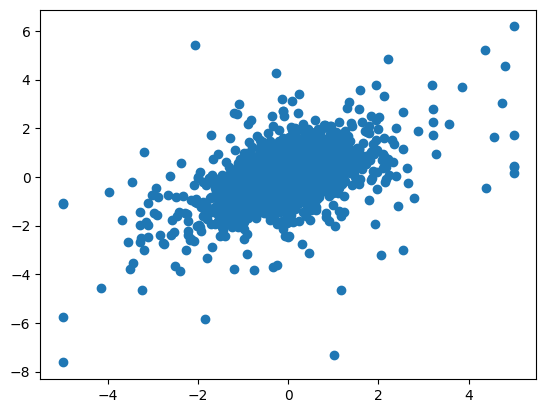

In [ ]:
# scatter plot of cleaned data
plt.scatter(X_norm, y_norm)

In [ ]:
# compute beta_real on cleaned data
cos_theta_clean = np.dot(X_norm, y_norm) / (np.linalg.norm(X_norm) * np.linalg.norm(y_norm))
beta_real_clean = cos_theta_clean * (np.linalg.norm(y_norm) / np.linalg.norm(X_norm))
beta_real_clean

np.float64(0.5478585125342521)

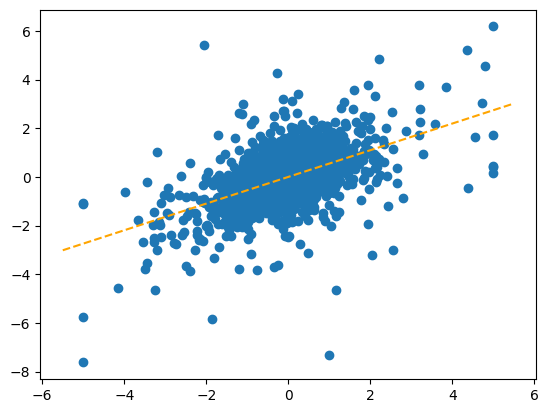

In [ ]:
# scatter plot of cleaned data with beta line
plt.scatter(X_norm, y_norm)
x_vals = np.array(plt.gca().get_xlim())
y_vals_clean = beta_real_clean * x_vals
plt.plot(x_vals, y_vals_clean, '--', color='orange')
plt.show()

In [ ]:
# Compute beta from y to X
cos_theta_y_to_X = np.dot(y, X) / (np.linalg.norm(y) * np.linalg.norm(X))
beta_y_to_X = cos_theta_y_to_X * (np.linalg.norm(X) / np.linalg.norm(y))
beta_y_to_X

np.float64(0.4623382914938485)

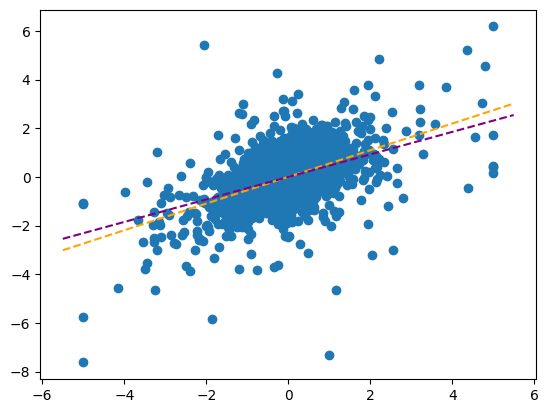

In [ ]:
# scatter plot of cleaned data with beta line
plt.scatter(X_norm, y_norm)
x_vals = np.array(plt.gca().get_xlim())
y_vals = beta_real_clean * x_vals
plt.plot(x_vals, y_vals, '--', color='orange')
y_vals_reverse = beta_y_to_X * x_vals
plt.plot(x_vals, y_vals_reverse, '--', color='purple')
plt.show()

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [ ]:
def r2(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    ss_tot = np.mean((y_true) ** 2)
    return 1 - (mse / ss_tot)

In [ ]:
y_true = y_norm.values
y_pred = beta_real_clean * X_norm.values
mse_value = mse(y_true, y_pred)
r2_value = r2(y_true, y_pred)
print(f"MSE: {mse_value:.6f}, R2: {r2_value:.6f}")

MSE: 0.720570, R2: 0.279106


Text(0.5, 1.0, 'y_true vs y_pred')

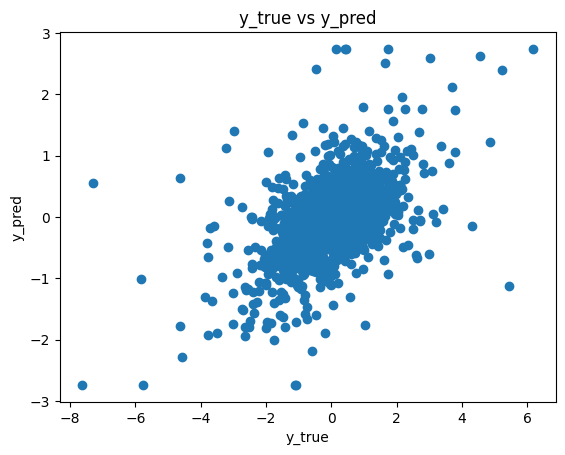

In [ ]:
# Scatter y_true vs y_pred
plt.scatter(y_true, y_pred)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("y_true vs y_pred")

## 7: Betas with Multiple Predictors

In [ ]:
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()
# Store means/stds of train_df and normalize
train_means = {}
train_stds = {}
for col in predictors + [responder]:
    mean = train_df[col].mean()
    std = train_df[col].std()
    train_means[col] = mean
    train_stds[col] = std
    train_df_norm[col] = (train_df[col] - mean) / std
    test_df_norm[col] = (test_df[col] - mean) / std

In [ ]:
# clip predictors to 5 stdevs
clip_value = 5
for col in predictors:
    train_df_norm[col] = train_df_norm[col].copy().clip(-clip_value, clip_value)
    test_df_norm[col] = test_df_norm[col].copy().clip(-clip_value, clip_value)

In [ ]:
X = train_df_norm[predictors]
y = train_df_norm[responder]

In [ ]:
# Compute betas with normal equation (no bias)
X_matrix = X.values
y_vector = y.values.reshape(-1, 1)
betas = np.linalg.pinv(X_matrix.T @ X_matrix) @ X_matrix.T @ y_vector
betas = betas.flatten()
betas

array([0.14862456, 0.2773543 , 0.08390346, 0.11778063, 0.19714955])

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [ ]:
def r2(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    ss_tot = np.mean((y_true) ** 2)
    return 1 - (mse / ss_tot)

In [ ]:
y_pred = X_matrix @ betas
y_true = y.values
mse_value = mse(y_true, y_pred)
r2_value = r2(y_true, y_pred)
print(f"MSE: {mse_value:.6f}, R2: {r2_value:.6f}")

MSE: 0.594803, R2: 0.404929


Text(0.5, 1.0, 'y_true vs y_pred')

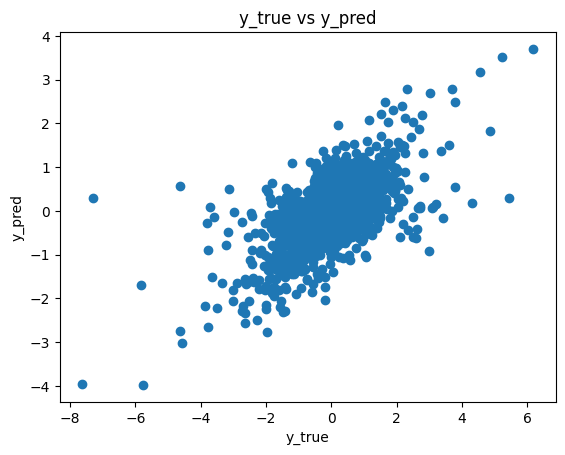

In [ ]:
# scatter y_true vs y_pred
plt.scatter(y_true, y_pred)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("y_true vs y_pred")

## 8: Evaluating on the Test Set

In [ ]:
y_test = test_df_norm[responder].values
X_test = test_df_norm[predictors].values
y_test_pred = X_test @ betas

In [ ]:
# Get the MSE and r2
mse_test = mse(y_test, y_test_pred)
r2_test = r2(y_test, y_test_pred)
print(f"Test MSE: {mse_test:.6f}, Test R2: {r2_test:.6f}")


Test MSE: 0.377600, Test R2: 0.625342


Text(0.5, 1.0, 'y_true vs y_pred')

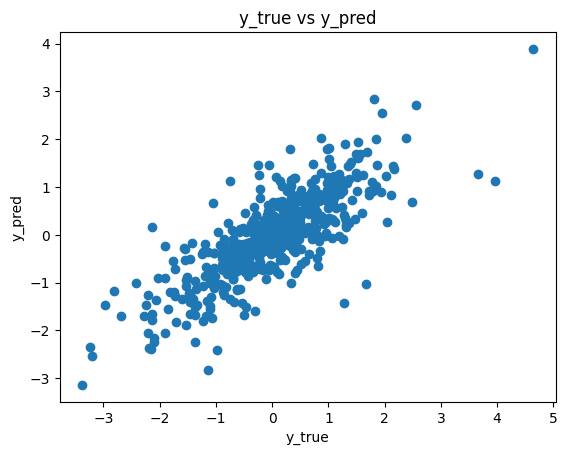

In [ ]:
# scatter y_true vs y_pred
plt.scatter(y_test, y_test_pred)
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("y_true vs y_pred")

## 9: Let's Trade!

In [ ]:
# basic strategy that always buys when pred is positive, always sells when pred is negative
def naive_trading_strategy(y_pred):
    # Returns 1 for buy, -1 for sell, 0 for hold
    # Uses vectorization
    move = np.zeros(len(y_pred))
    move[y_pred > 0] = 1  # Buy
    move[y_pred < 0] = -1  # Sell
    return move

In [ ]:
# smarter strategy that only trades when abs(pred) > threshold
def threshold_trading_strategy(y_pred, threshold=1):
    # Returns 1 for buy, -1 for sell, 0 for hold
    # Uses vectorization
    move = np.zeros(len(y_pred))
    move[y_pred > threshold] = 1  # Buy
    move[y_pred < -threshold] = -1  # Sell
    return move

In [ ]:
def compute_pnl(y_true, moves):
    return y_true * moves


In [ ]:
y_true = y_test * train_stds[responder] + train_means[responder]  # Denormalize


In [ ]:
naive_moves = naive_trading_strategy(y_test_pred)
naive_pnl = compute_pnl(y_true, naive_moves)

In [ ]:
thresh_moves = threshold_trading_strategy(y_test_pred, threshold=0.5)
thresh_pnl = compute_pnl(y_true, thresh_moves)

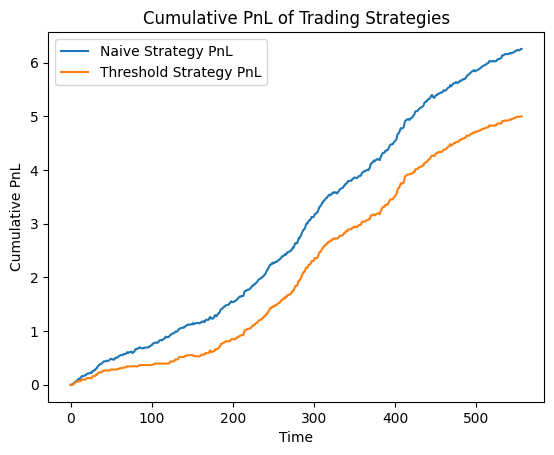

In [ ]:
# cumulative pnl plots
plt.plot(np.cumsum(naive_pnl), label='Naive Strategy PnL')
plt.plot(np.cumsum(thresh_pnl), label='Threshold Strategy PnL')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL of Trading Strategies')
plt.legend()

In [ ]:
# is our strategy high t-stat?

def t_stat(pnl):
    return pnl.mean() / (pnl.std()) * np.sqrt(len(pnl))

In [ ]:
naive_pnl.mean(), naive_pnl.std()

(np.float64(0.011235657471964321), np.float64(0.014394183236495578))

In [ ]:
thresh_pnl.mean(), thresh_pnl.std()

(np.float64(0.008976677763131026), np.float64(0.013841795289997802))

In [ ]:
print("Naive Strategy t-stat:", t_stat(naive_pnl))
print("Threshold Strategy t-stat:", t_stat(thresh_pnl))

Naive Strategy t-stat: 18.42209686748326
Threshold Strategy t-stat: 15.30561592544548


## 10: Improvements?